# Modelling - Support Vector Classifier

## Goal:

Using user names and descriptions, I will build a model to predict a person's political leanings, that being liberal or conservative.

### Contents:
- [1. Importing libraries](#1.-Importing-libraries)
- [2. Importing datasets](#2.-Importing-datasets)
- [3. Model hyperparameter tuning](#3.-Model-hyperparameter-tuning)
- [4. Building the model](#4.-Data-Cleaning)
- [5. Model validation and evaluation](#5.-Model-validation-and-evaluation)

## 1. Importing libraries

In [2]:
import pandas as pd
import pleiades as ple
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
pd.options.display.max_columns=110
pd.options.display.max_rows=300

## 2. Importing datasets

In [6]:
import_path = r'..\data\#michellewilliams_users_clean.csv'
df = pd.read_csv(import_path, index_col=0)

import_path = r'..\data\replies_to_jk_rowling_users_clean.csv'
df2 = pd.read_csv(import_path, index_col=0)

In [7]:
df.head()

,name_and_description,conservative
0,Boris Is My Prime Minister ✡ ️ 🇬🇧,1.0
1,🇺🇸 🇺🇸 Red Blooded All American 🌾 Heartland bo...,1.0
2,Indian singer Army brat Muay Thai panda Horse ...,0.0
3,Christian SC Gamecocks College Football Outdoo...,1.0
4,Mother of Amma to love my kids love my grandki...,1.0


In [8]:
df = df.fillna('')
df2 = df2.fillna('')

In [9]:
X = df['name_and_description']
X_val = df2['name_and_description']
y = df['conservative'].values
y_val = df2['conservative'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)
sebas = ple.Sebastian()

## 3. Model hyperparameter tuning

In [14]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', token_pattern=r'([^\s]+)')),
    ('svc', SVC(gamma='scale'))
])
params = {
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_df': [.3, .6, .9],
    'tvec__min_df': [1, 3, 7],
    'tvec__max_features': [2000, 5000, 10000],
    'svc__C': [0.5, 1, 2],
    'svc__kernel': ['linear'],
}
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
# best score: 0.8181384248210024
print('best score:', gs.best_score_)
# best params: svc: C=0.5, kernel='linear' tvec: max_df=0.3, max_features=2000, min_df=3, ngram_range=(1, 2), stop_words='english'
print('best params:', sebas.get_params(gs.best_params_))
print()

best score: 0.8181384248210024
best params: svc: C=0.5, kernel='linear' tvec: max_df=0.3, max_features=2000, min_df=3, ngram_range=(1, 2), stop_words='english'



## 4. Building the model

In [11]:
tvec = TfidfVectorizer(max_df=0.3, max_features=2000, min_df=3, ngram_range=(1, 2), stop_words='english', token_pattern=r'([^\s]+)')
X_train = tvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=tvec.get_feature_names())
X_test = tvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=tvec.get_feature_names())
X_val = tvec.transform(X_val)
X_val = pd.DataFrame(X_val.toarray(), columns=tvec.get_feature_names())

In [11]:
print('TfidfVectorizer:')
print(X_train.sum().sort_values(ascending=False)[:10])

TfidfVectorizer:
️               165.660758
🇺🇸              162.587553
love            113.965834
maga            110.764999
trump           106.812452
life             80.994739
⭐                79.005003
❤                67.392424
god              64.871124
conservative     61.364692
dtype: float64


In [9]:
svc = SVC(gamma='scale', C=0.5, kernel='linear')
svc.fit(X_train, y_train)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
pickle.dump(svc, open(r'..\pickles\model_svc.sav', 'wb'))

## 5. Model validation and evaluation

In [3]:
with open(r'..\pickles\model_svc.sav', 'rb') as f:
    svc = pickle.load(f)

In [4]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [13]:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [12]:
y_pred = svc.predict(X_test)
y_pred2 = svc.predict(X_val)

In [14]:
sebas = ple.Sebastian()

### Plot terms that predict a person is conservative

In [15]:
print('most_important_features:', sebas.get_features(X_train, svc.coef_.ravel(), order='dsc'))
print()

most_important_features: {'maga': 5.047621274274541, 'conservative': 4.293623164463273, 'christian': 3.5090378708782852, '🇺🇸': 3.0397387891089696, 'catholic': 2.934071381114508, 'jesus': 2.559408971672141, 'patriot': 2.553508992956866, 'god': 2.4740016509442726, 'kag': 2.4298648164237777, '❌': 1.957153719633246, 'married': 1.9570610748031745, 'wwg1wga': 1.9570212039404953, 'pro life': 1.8508447553563, 'government': 1.8440755145822936, 'trump': 1.8202595918775213, '⭐': 1.7956385738789125, 'american': 1.743884230694408, 'christ': 1.6220468810118918, 'country': 1.6145064003576983, 'trump 2020': 1.5912490460800142, 'pro': 1.5681648365885779, 'america': 1.5671097849102191, 'usa': 1.5515073858364477, 'truth': 1.5472431952311154, '✝': 1.4935593646250458, '2a': 1.421904592000435, 'liberals': 1.338960687444365, '🌟': 1.3352304747348742, 'prolife': 1.329026584116146, 'parler': 1.303141660846068, 'president trump': 1.279580593796337, 'horses': 1.269556734900267, 'deplorable': 1.2617715200750388, '

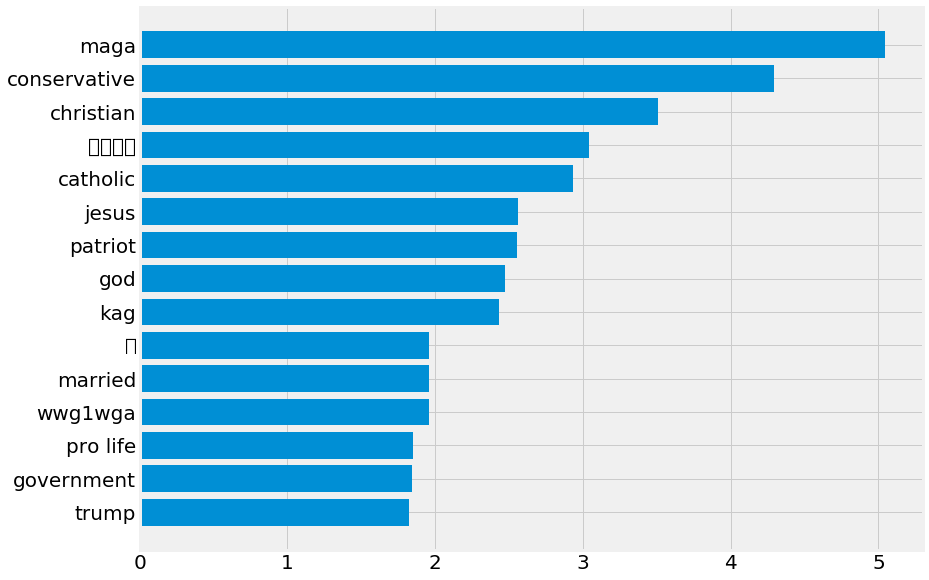

In [27]:
sebas.plot_importances(max_features=15, figsize=(12.5, 10))

### Plot terms that predict a person is liberal

In [21]:
print('most_important_features:', sebas.get_features(X_train, svc.coef_.ravel(), order='asc'))
print()

most_important_features: {'resist': -2.037724804745416, 'resistance': -1.7287218654939454, '🌊': -1.4529574740871685, 'instagram': -1.0311477362699832, 'democracy': -1.0001916259768688, 'democrat': -0.9955145787581257, 'fbr': -0.9284589111066389, 'concerned': -0.8373449139897252, 'impeach': -0.8125686894033506, 'blue': -0.7691373503581298, 'equality': -0.7653740671434177, 'passionate': -0.7586119223195191, '🌈': -0.7579311909037365, 'resister': -0.7449296322036774, 'russian': -0.7196912019824926, 'geek': -0.7096479515271754, 'women': -0.7015042186729161, 'pro choice': -0.6956767959418961, 'reader': -0.6850334974967318, '🌙': -0.6750898812991233, 'environment': -0.6706524284422465, 'thing': -0.6695290182771383, 'feminist': -0.666090723055774, 'demand': -0.6614131122187865, 'kind': -0.6527264030697427, 'vote': -0.6522649736938806, 'russia': -0.6520357141012741, 'peace': -0.6503544796329577, 'use': -0.6250205946894555, 'actor': -0.6217229549807964, 'science': -0.6140579888350743, 'school': -

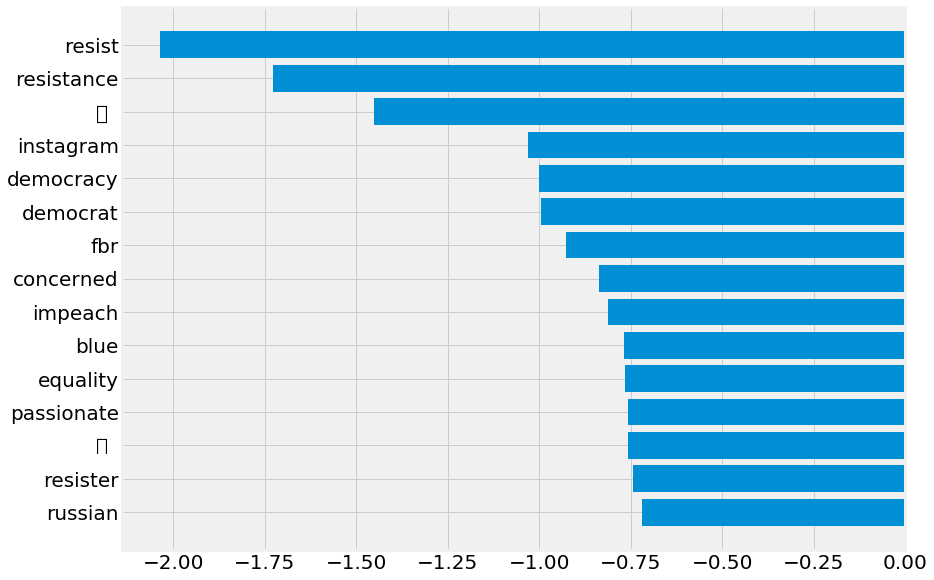

In [28]:
sebas.plot_importances(max_features=15, figsize=(12.5, 10), order='asc')

### Run model on test and validation set

In [18]:
print(classification_report(y_test, y_pred, output_dict=False))

              precision    recall  f1-score   support

         0.0       0.75      0.97      0.85      1169
         1.0       0.95      0.60      0.74       927

    accuracy                           0.81      2096
   macro avg       0.85      0.79      0.79      2096
weighted avg       0.84      0.81      0.80      2096



In [19]:
print(confusion_matrix(y_test, y_pred))

[[1138   31]
 [ 370  557]]


In [20]:
print(classification_report(y_val, y_pred2, output_dict=False))

              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       781
         1.0       0.83      0.26      0.39       166

    accuracy                           0.86       947
   macro avg       0.84      0.62      0.66       947
weighted avg       0.86      0.86      0.83       947



In [21]:
print(confusion_matrix(y_val, y_pred2))

[[772   9]
 [123  43]]


### Conclusion

- The model proved to be reasonably accurate in predicting the political leanings of a person, with an accuracy of 81% on the test dataset and 85% on the validation dataset. This shows that the model is not overfitted.
- However, many of the terms that the model used to predict a person's political leanings are dependent on the current political climate in the United States, which are likely to change every 4 years.
- It also needs to be kept in mind that the model was trained on an English speaking, mostly American subset of the twitter population. While it appears to be reasonably accurate on English twitter on European topics, it may not be as accurate in less westernized English speaking countries like Singapore.